In [1]:
import time
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, accuracy_score, roc_auc_score, f1_score, make_scorer, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap

In [2]:
def feature_prop(df, add=False, formerdict=None):
    """
    Analyse les caractéristiques des colonnes d'un DataFrame et retourne un dictionnaire
    contenant des informations sur le type et les propriétés de chaque colonne.

    Parameters:
    ----------
    df : pandas.DataFrame
        Le DataFrame à analyser.
    
    add : bool, optionnel
        Si True, ajoute les nouvelles informations au dictionnaire existant fourni dans 'formerdict'.
        Sinon, crée un nouveau dictionnaire. (Par défaut : False)
    
    formerdict : dict, optionnel
        Un dictionnaire existant de caractéristiques de colonnes à mettre à jour (Par défaut : None).
    
    Returns:
    -------
    dict
        Un dictionnaire contenant les caractéristiques des colonnes du DataFrame, comme le type,
        si les valeurs sont binaires, strictement positives ou négatives, etc.
    """
    # Initialiser le dictionnaire pour stocker les résultats
    column_characteristics = formerdict if add and formerdict else {}

    # Parcourir chaque colonne du DataFrame
    for column in df.columns:
        col_data = df[column]
        if pd.api.types.is_numeric_dtype(col_data):
            col_info = {
                'type': 'numeric',
                'between_0_and_1': col_data.between(0, 1).all(),  # Vérifie si les valeurs sont entre 0 et 1
                'binary': col_data.isin([0, 1]).all(),  # Vérifie si la colonne est binaire (0 ou 1)
                'strictly_positive': (col_data > 0).all(),  # Vérifie si toutes les valeurs sont strictement positives
                'strictly_negative': (col_data < 0).all()  # Vérifie si toutes les valeurs sont strictement négatives
            }
        else:
            col_info = {
                'type': 'categorical',
                'classes': col_data.unique().tolist()  # Liste les classes uniques dans les colonnes catégorielles
            }
        
        # Ajouter ou mettre à jour les caractéristiques de la colonne dans le dictionnaire
        column_characteristics[column] = col_info

    return column_characteristics

# Fonction pour charger les variables personnalisées à partir d'un fichier CSV
def load_custom_variables():
    """
    Charge les variables personnalisées depuis le fichier 'custom_variables.csv'.
    Si le fichier n'est pas trouvé, un message d'erreur est affiché et toutes les variables
    sont utilisées par défaut.

    Returns:
    -------
    list
        Une liste de colonnes personnalisées si le fichier est trouvé, sinon la liste de toutes les colonnes.
    """
    try:
        custom_vars = pd.read_csv('custom_variables.csv', sep=';')
        return custom_vars.columns.tolist()
    except FileNotFoundError:
        print("Aucun fichier custom_variables.csv détecté. Utilisation de toutes les variables.")
        return all_columns  # Renvoie toutes les colonnes si le fichier n'existe pas

# Fonction pour identifier les variables binaires dans les caractéristiques
def which_binvariables(props):
    """
    Identifie les variables binaires parmi les caractéristiques des colonnes fournies.

    Parameters:
    ----------
    props : dict
        Un dictionnaire contenant les caractéristiques des colonnes retournées par la fonction `feature_prop`.

    Returns:
    -------
    list
        Une liste de noms de colonnes qui contiennent des variables binaires.
    """
    binaryvariables = []
    for key, values in props.items():
        if values['binary']:  # Si la colonne est binaire, elle est ajoutée à la liste
            binaryvariables.append(key)
    return binaryvariables

# Tracer la courbe ROC pour ROC AUC
def draw_roc_curv_roc_auc(ytest, ypredprobroc,model_name):
    fpr, tpr, _ = roc_curve(ytest, ypredprobroc)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (ROC AUC)')
    plt.legend(loc="lower right")
    plt.savefig(f"roc_curve_{model_name}_ROC_AUC.png")
    plt.show()

def draw_roc_curv_fbeta(ytest, ypredprobfbeta,model_name):
    fpr, tpr, _ = roc_curve(ytest, ypredprobfbeta)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (F10)')
    plt.legend(loc="lower right")
    plt.savefig(f"roc_curve_{model_name}_F10.png")
    plt.show()
    
# Tracer la matrice de confusion 
def plot_confusion_matrix_auc_roc(ytest, ypredprobroc,model_name):
            cm_roc = confusion_matrix(ytest, ypredprobroc)
            disp_roc = ConfusionMatrixDisplay(confusion_matrix=cm_roc)
            disp_roc.plot()
            plt.title(f'Table de Confusion - {model_name} (ROC AUC)')
            plt.savefig(f"confusion_matrix_{model_name}_ROC_AUC.png")
            plt.show()

def plot_confusion_matrix_fbeta(ytest,ypredprobfbeta,model_name):
            cm_roc = confusion_matrix(ytest, ypredprobfbeta)
            disp_roc = ConfusionMatrixDisplay(confusion_matrix=cm_roc)
            disp_roc.plot()
            plt.title(f'Table de Confusion - {model_name} (F10)')
            plt.savefig(f"confusion_matrix_{model_name}_F10.png")
            plt.show()
            
def plot_calibration_curve(y_true, y_prob, model_name):
    """
    Plots the calibration curve for a probabilistic model.

    Parameters:
    y_true (array-like): True labels.
    y_prob (array-like): Predicted probabilities.
    model_name (str): Name of the model (for plot title).
    """

    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

    # Plot calibration curve
    plt.figure(figsize=(10, 7))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

    plt.title(f'Calibration Curve for {model_name}')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"calibration_curve_{model_name}.png")
    plt.show()

    # Optionally log to MLflow
    mlflow.log_artifact(f"calibration_curve_{model_name}.png")

def collect_mlflow_model_perfs():
    import mlflow
    from mlflow.tracking import MlflowClient
    import os
    import pandas as pd
    import numpy as np
    
    # Connexion au serveur MLFlow
    mlflow.set_tracking_uri("http://localhost:5000")
    client = MlflowClient("http://127.0.0.1:5000")
    
    try:
        experiments = client.search_experiments(view_type=mlflow.entities.ViewType.ALL)
        print("Connexion au serveur MLflow. Expériences détectées:")
        for exp in experiments:
            print(f"Expérience ID: {exp.experiment_id}, Nom: {exp.name}")
    except Exception as e:
        print("Échec de la connexion au serveur MLflow:", e)
    
    # Utiliser l'experiment par défaut avec ID = 0
    experiment_id = "0"
    
    # Récupérer les runs pour l'experiment par défaut
    runs = client.search_runs(experiment_ids=[experiment_id])
    
    # Afficher les noms des runs
    run_names = [run.data.tags.get("mlflow.runName") for run in runs]
    for idx, run_name in enumerate(run_names):
        print(f"Run {idx+1}: {run_name}")
    
    # Pour chaque run, lire les métriques loggées avec arrondi à 2 chiffres
    Runs=[]
    MetricName=[]
    MetricValue=[]
    for run in runs:
        #print(f"Run ID: {run.info.run_id}")
        #print(f"Run Name: {run.data.tags.get('mlflow.runName')}")
        
        # Afficher toutes les métriques loggées pour ce run
        metrics = run.data.metrics
        for metric_name, metric_value in metrics.items():
            #print(f"{metric_name}: {round(metric_value, 2)}")
            Runs.append(run.data.tags.get('mlflow.runName'))
            MetricName.append(metric_name)
            MetricValue.append(metric_value)
        
        #print("-" * 40)
    
    
    
    compilation = pd.DataFrame({"Runs":Runs,"MetricName":MetricName,"MetricValue":MetricValue})
    best_model_per_metric= compilation.groupby("MetricName").apply(lambda x: x[["Runs","MetricValue"]][x["MetricValue"]==np.max(x["MetricValue"])] )
    best_model_per_metric["MetricName"]=[i[0] for i in best_model_per_metric.index]
    best_model_per_metric_test=best_model_per_metric.loc[best_model_per_metric.MetricName.str.contains("test"),:]
    best_model_per_metric_test.sort_values("Runs")
    return best_model_per_metric_test
    mlflow.end_run()
    
def collect_mlflow_model_hyperparams():
    import mlflow
    from mlflow.tracking import MlflowClient
    import pandas as pd

    # Step 1: Connect to MLflow server
    mlflow.set_tracking_uri("http://localhost:5000")
    client = MlflowClient("http://127.0.0.1:5000")

    try:
        # Step 2: Search for all experiments
        experiments = client.search_experiments(view_type=mlflow.entities.ViewType.ALL)
        print("Connexion au serveur MLflow. Expériences détectées:")
        for exp in experiments:
            print(f"Expérience ID: {exp.experiment_id}, Nom: {exp.name}")
    except Exception as e:
        print("Échec de la connexion au serveur MLflow:", e)
        return

    # Step 3: Use the default experiment (ID = 0)
    experiment_id = "0"

    # Step 4: Search for runs in the selected experiment
    runs = client.search_runs(experiment_ids=[experiment_id])

    # Step 5: Initialize lists to store the hyperparameters (params) for each run
    Runs = []
    ParamName = []
    ParamValue = []

    # Step 6: Loop through each run and collect hyperparameters
    for run in runs:
        #print(f"Run ID: {run.info.run_id}")
        #print(f"Run Name: {run.data.tags.get('mlflow.runName')}")

        # Retrieve all logged hyperparameters (params) for the current run
        params = run.data.params
        for param_name, param_value in params.items():
            #print(f"Hyperparameter - {param_name}: {param_value}")
            Runs.append(run.data.tags.get('mlflow.runName'))
            ParamName.append(param_name)
            ParamValue.append(param_value)
        
        #print("-" * 40)

    # Step 7: Create a DataFrame with the collected hyperparameters
    hyperparams_df = pd.DataFrame({"Run": Runs, "ParamName": ParamName, "ParamValue": ParamValue})
    
    # Optional: Sort or filter based on hyperparameters, if needed
    sorted_hyperparams_df = hyperparams_df.sort_values(by=["Run", "ParamName"])

    #print("Hyperparameters collected:")
    #print(sorted_hyperparams_df)
    mlflow.end_run()

    return sorted_hyperparams_df

def select_models():
    if "GradientBoosting" in best_model_name:
        param_grid = {
            'model__n_estimators': range(float(best_params['model__n_estimators']) - 5, float(best_params['model__n_estimators']) + 6, 1),
            'model__max_depth': [best_params['model__max_depth']],
            'model__learning_rate': [round(x, 2) for x in np.arange(float(best_params['model__learning_rate']) - 0.1, float(best_params['model__learning_rate']) + 0.12, 0.02)],
            'model__subsample': [round(x, 2) for x in np.arange(float(best_params['model__subsample']) - 0.1, float(best_params['model__subsample']) + 0.12, 0.02)],
            'model__min_samples_split': [float(best_params['model__min_samples_split'])],
            'model__min_samples_leaf': [float(best_params['model__min_samples_leaf'])]
        }
        best_refined_model = GradientBoostingClassifier()
    
    elif "LogisticRegression" in best_model_name:
        param_grid = {
            'model__C': [round(max(x, 0), 2) for x in np.arange(float(best_params['model__C']) - 1, float(best_params['model__C']) + 1.02, 0.02)],
            'model__penalty': [best_params['model__penalty']]
        }
        best_refined_model = LogisticRegression(solver='liblinear', max_iter=500)
    
    elif "NeuralNetwork" in best_model_name:
        param_grid = {
            'model__hidden_layer_sizes': [best_params['model__hidden_layer_sizes']],
            'model__activation': [best_params['model__activation']],
            'model__solver': [best_params['model__solver']],
            'model__alpha': [round(x, 4) for x in np.arange(best_params['model__alpha'] - 0.01, best_params['model__alpha'] + 0.012, 0.002)],
            'model__learning_rate': [best_params['model__learning_rate']]
        }
        best_refined_model = MLPClassifier(max_iter=500)
    
    else:
        raise ValueError(f"Unknown model type in best_model_name: {best_model_name}. Please check the 'best_model_name' value.")
    return param_grid,best_refined_model

from sklearn.metrics import confusion_matrix, fbeta_score
import numpy as np

def find_best_cutoff(y_true, y_pred_prob, beta=10):
    """
    Finds the best cutoff threshold for y_pred_prob based on the highest F-beta score.
    
    Args:
    y_true: Actual labels.
    y_pred_prob: Predicted probabilities of the positive class.
    beta: Beta value for F-beta score. Default is 10.

    Returns:
    best_cutoff: Cutoff threshold with the highest F-beta score.
    best_fbeta: The highest F-beta score.
    fbeta_dict: A dictionary of cutoffs and corresponding F-beta scores.
    """
    best_cutoff = 0
    best_fbeta = 0
    fbeta_dict = {}    
    for cutoff in np.arange(0.01, 1, 0.01):
        y_pred_cutoff = (y_pred_prob >= cutoff).astype(int)
        cm = confusion_matrix(y_true, y_pred_cutoff)
        tn, fp, fn, tp = cm.ravel()
        try:
            fbeta = fbeta_score(y_true, y_pred_cutoff, beta=beta)
        except ValueError:
            # si toutes les predictions sont 0 ou 1
            continue
        fbeta_dict[cutoff] = fbeta
        if fbeta > best_fbeta:
            best_fbeta = fbeta
            best_cutoff = cutoff
    return best_cutoff, best_fbeta, fbeta_dict

def plot_confusion_matrix_fbeta(ytest,ypredprobfbeta,model_name):
            cm_roc = confusion_matrix(ytest, ypredprobfbeta)
            disp_roc = ConfusionMatrixDisplay(confusion_matrix=cm_roc)
            disp_roc.plot()
            plt.title(f'Table de Confusion - {model_name} (F10)')
            plt.savefig(f"confusion_matrix_{model_name}_F10.png")
            #plt.show()
def plot_confusion_matrix_auc_roc(ytest, ypredprobroc,model_name):
            cm_roc = confusion_matrix(ytest, ypredprobroc)
            disp_roc = ConfusionMatrixDisplay(confusion_matrix=cm_roc)
            disp_roc.plot()
            plt.title(f'Table de Confusion - {model_name} (ROC AUC)')
            plt.savefig(f"confusion_matrix_{model_name}_ROC_AUC.png")
            #plt.show()

from mlflow import MlflowClient
import joblib

def register_and_promote_model(best_model, model_name, artifact_path, run_id, stage="Production"):
    """
    Enregistre et promeut un modèle dans le Model Registry de MLflow.

    Parameters:
    best_model: Le modèle à enregistrer
    model_name: Nom du modèle pour le Model Registry
    artifact_path: Le chemin de l'artefact du modèle (ex: "final_model.joblib")
    run_id: ID du run en cours dans MLflow
    stage: Le stage dans lequel promouvoir le modèle (default: "Production")
    """

    joblib.dump(best_model, artifact_path)
    

    mlflow.log_artifact(artifact_path)
    
   
    model_uri = f"runs:/{run_id}/{artifact_path}"
    
    try:
        
        registered_model = mlflow.register_model(model_uri=model_uri, name=model_name)
        print(f"Modèle {model_name} enregistré.")
        

        
        latest_version_info = client.get_latest_versions(name=model_name, stages=["None"])
        
        if latest_version_info:
            latest_version = latest_version_info[0].version

            client.transition_model_version_stage(
                name=model_name,
                version=latest_version,
                stage=stage
            )
            print(f"Modèle {model_name} version {latest_version} promu en {stage}.")
            
    except Exception as e:
        print(f"Erreur lors de l'enregistrement ou de la promotion du modèle: {e}")



In [3]:
res_collect_perfs = collect_mlflow_model_perfs()
res_collect_params= collect_mlflow_model_hyperparams()
res_collect_params.head()

Connexion au serveur MLflow. Expériences détectées:
Expérience ID: 0, Nom: Default
Run 1: final_model_with_roc_auc
Run 2: final_model_with_roc_auc
Run 3: final_model_with_roc_auc
Run 4: LogisticRegression_F10
Run 5: LogisticRegression_ROC_AUC
Connexion au serveur MLflow. Expériences détectées:
Expérience ID: 0, Nom: Default


/tmp/ipykernel_19309/1521715507.py:215: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_model_per_metric= compilation.groupby("MetricName").apply(lambda x: x[["Runs","MetricValue"]][x["MetricValue"]==np.max(x["MetricValue"])] )


,Run,ParamName,ParamValue
1,LogisticRegression_F10,model__C,0.011557531682028657
0,LogisticRegression_F10,model__penalty,l2
3,LogisticRegression_ROC_AUC,model__C,0.011557531682028657
2,LogisticRegression_ROC_AUC,model__penalty,l2


Connexion au serveur MLflow. Expériences détectées:
Expérience ID: 0, Nom: Default
X shape (49406, 21)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


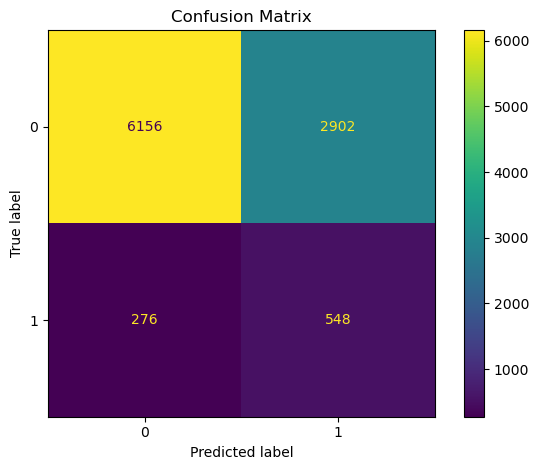

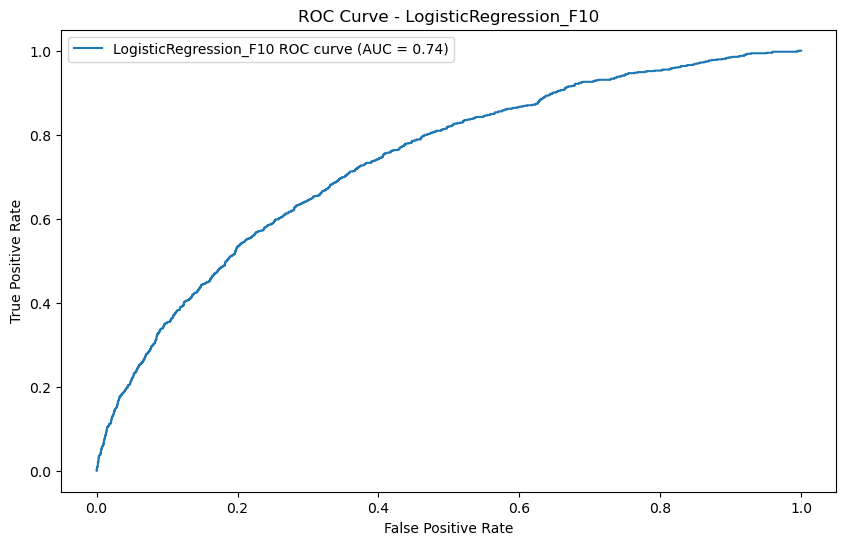

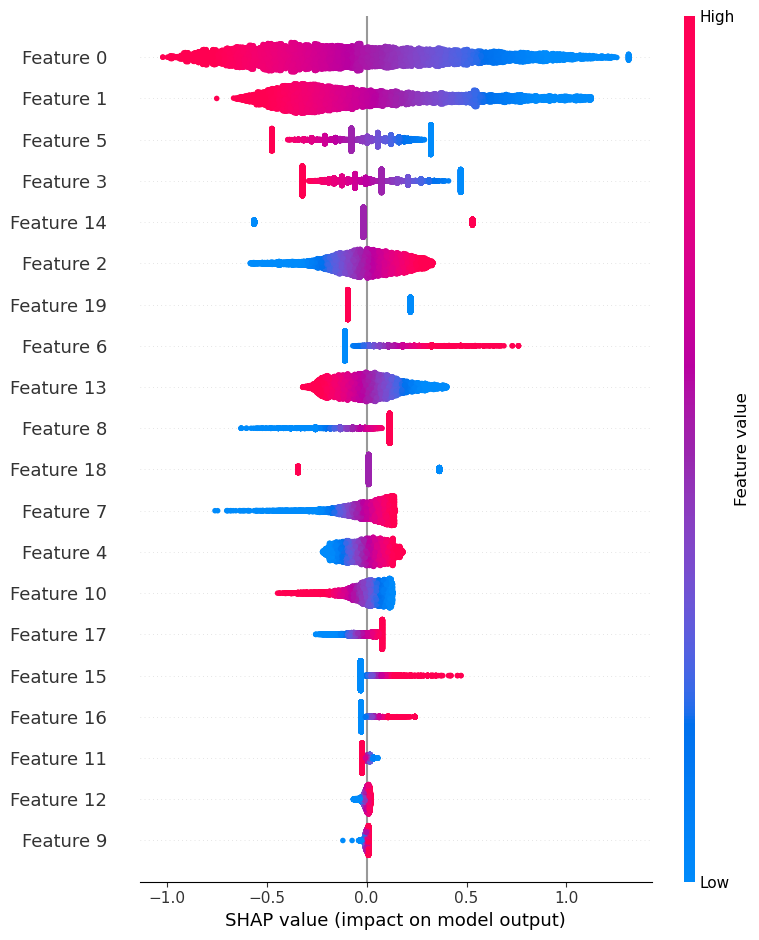

2024/09/29 14:13:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_F10' already exists. Creating a new version of this model...
2024/09/29 14:13:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_F10, version 2
Created version '2' of model 'LogisticRegression_F10'.
/tmp/ipykernel_19309/1521715507.py:392: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_version_info = client.get_latest_versions(name=model_name, stages=["None"])
/tmp/ipykernel_

Modèle LogisticRegression_F10 enregistré.
Modèle LogisticRegression_F10 version 2 promu en Production.
Temps d'exécution total: 8.14 secondes


<Figure size 640x480 with 0 Axes>

In [4]:
best_model_name = "LogisticRegression_F10"
df_select_params = res_collect_params[res_collect_params.Run==best_model_name]
hyper_params = {row['ParamName']: row['ParamValue'] for _, row in df_select_params.iterrows()}
best_params=hyper_params

#Assuming the 'select_models' function and other necessary custom functions are defined elsewhere

# Start the timer
start_time = time.time()

# Load data
description_columns = pd.read_csv('../data/HomeCredit_columns_description.csv', sep=",", index_col=0, header=0, encoding='latin1')
description_columns_dictionary = dict(zip(description_columns['Row'], description_columns['Description']))

X = pd.read_csv("../data/imputed_working_data.csv")
X = X.set_index("SK_ID_CURR")



# Assuming feature_prop and which_binvariables are defined elsewhere
col_caracteristics = feature_prop(df=X)
binaryvariables = which_binvariables(col_caracteristics)

# Model path setup
model_path = "mlflow_model"
if os.path.exists(model_path) and os.listdir(model_path):
    shutil.rmtree(model_path)
os.makedirs(model_path, exist_ok=True)

# Connect to MLFlow server
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient("http://127.0.0.1:5000")

try:
    experiments = client.search_experiments(view_type=mlflow.entities.ViewType.ALL)
    print("Connexion au serveur MLflow. Expériences détectées:")
    for exp in experiments:
        print(f"Expérience ID: {exp.experiment_id}, Nom: {exp.name}")
except Exception as e:
    print("Échec de la connexion au serveur MLflow:", e)


############################# Data ###################################################################
# Define preprocessing step
OHEprefix = binaryvariables
numeric_columns = [col for col in X.columns if not any(col.startswith(prefix) for prefix in OHEprefix)]
X_train, X_test, y_train, y_test = train_test_split(X.drop(["TARGET"], axis=1), X["TARGET"], test_size=0.2, random_state=42)

save_tests = X_test.copy()
save_tests["TARGET"] = y_test
save_tests.to_csv("data_prod.csv")
print("X shape",X.shape)
# Create the preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_columns)], remainder='passthrough')

# SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Define models and parameter grid for search
param_grid, best_refined_model = select_models()
param_grid['model__C']=list(np.asarray(param_grid['model__C'])[np.asarray(param_grid['model__C'])>0])

# Define F10 scorer
f10_scorer = make_scorer(fbeta_score, beta=10)

# Create pipeline with preprocessor and SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', best_refined_model)
])

# Grid search for the best model
with mlflow.start_run(run_name="final_model_with_roc_auc"):
    
    active_run = mlflow.active_run()
    
    if active_run:
        run_id = active_run.info.run_id
    else:
        raise Exception("Aucun run actif trouvé. Impossible d'enregistrer le modèle.")
    
    refined_search_fbeta = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring="roc_auc",
        cv=5,
        verbose=2,
        n_jobs=-1,
        return_train_score=True
    )
    refined_search_fbeta.fit(X_train, y_train)
    best_refined_model = refined_search_fbeta.best_estimator_
    
    # Predictions
    y_pred_train = best_refined_model.predict(X_train)
    y_pred_prob_train = best_refined_model.predict_proba(X_train)[:, 1]
    y_pred = best_refined_model.predict(X_test)
    y_pred_prob = best_refined_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train, average='macro')
    train_roc_auc = roc_auc_score(y_train, y_pred_prob_train)
    
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    test_roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    train_fbeta = fbeta_score(y_train, y_pred_train, beta=10)
    test_fbeta = fbeta_score(y_test, y_pred, beta=10)

    # Cross-validation results
    cv_train_mean_score_fbeta = refined_search_fbeta.cv_results_['mean_train_score'].mean()
    cv_test_mean_score_fbeta = refined_search_fbeta.cv_results_['mean_test_score'].mean()

    # Log metrics to MLflow
    mlflow.log_metrics({
        "train_accuracy": train_accuracy,
        "train_f1_score": train_f1,
        "train_roc_auc": train_roc_auc,
        "test_accuracy": test_accuracy,
        "test_f1_score": test_f1,
        "test_roc_auc": test_roc_auc,
        "train_fbeta_score": train_fbeta,
        "test_fbeta_score": test_fbeta,
        "cv_train_mean_score_fbeta": cv_train_mean_score_fbeta,
        "cv_test_mean_score_fbeta": cv_test_mean_score_fbeta
    })

    #################### Feature Importance ####################
    if hasattr(best_refined_model.named_steps['model'], 'feature_importances_'):
        feature_importances = best_refined_model.named_steps['model'].feature_importances_
        feature_names = X_train.columns
    
        sorted_idx = np.argsort(feature_importances)[::-1]
    
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
        plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
        plt.title('Feature Importances')
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
    
    #################### Confusion Matrix ####################
    plot_confusion_matrix_fbeta(ytest = y_test, ypredprobfbeta = y_pred, model_name = best_model_name)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    #################### ROC Curve ####################
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{best_model_name} ROC curve (AUC = {test_roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc="best")
    plt.show()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    
    #################### SHAP Values ####################
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    explainer = shap.Explainer(best_refined_model.named_steps['model'], X_train_transformed)
    shap_values = explainer(X_test_transformed)
    shap.summary_plot(shap_values, X_test_transformed)
    plt.show()
    plt.savefig("shap_global_importance.png")
    mlflow.log_artifact("shap_global_importance.png")
    
    # Save model
    joblib.dump(best_refined_model, "final_model.joblib")
    mlflow.log_artifact("final_model.joblib")
    mlflow.sklearn.log_model(best_refined_model, f"{best_model_name}_final_roc_auc_model")
    register_and_promote_model(
        best_model=best_refined_model, 
        model_name=best_model_name,  
        artifact_path="final_model.joblib",  
        run_id=run_id,  
        stage="Production"  
    )

mlflow.end_run()

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps d'exécution total: {elapsed_time:.2f} secondes")
